In [167]:
import random
import re
from collections import Counter

import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm

In [168]:
class Vocabulary:

    def __init__(self, texts: [str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self.vocabulary.append('<pad>')

        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()

        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def get_pad(self):
        return self.word2idx('<pad>')

    def build_vectors(self, fasttext):
        vectors = []

        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

In [169]:
class IMDB(Dataset):

    def __init__(self, df, vocab):
        self.df = df

        self.vocab = vocab

        self.label2idx = {
            'positive': 0,
            'negative': 1
        }

    def __getitem__(self, idx):
        text = self.df['review'].loc[idx]
        label = self.label2idx[self.df['sentiment'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

In [170]:
class TextCNN(nn.Module):

    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels=1,
                    out_channels=32,
                    kernel_size=(fs, embedding_dim))
                for fs in [2, 3, 4, 5, 6]
            ]
        )

        self.fc = nn.Linear(5 * 32, 1)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim=1))

        return self.fc(x)

In [171]:
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [172]:
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [173]:
def train(
        model: nn.Module,
        data_loader: DataLoader,
        optimizer: Optimizer,
        loss_fn,
        device: torch.device
):
    model.train()

    train_loss = 0
    train_accuracy = 0

    for x, y in tqdm(data_loader, desc='Train'):
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_accuracy += binary_accuracy(output, y).item()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_accuracy /= len(data_loader)

    return train_loss, train_accuracy


@torch.inference_mode()
def evaluate(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn,
        device: torch.device
):
    model.eval()

    total_loss = 0
    total_accuracy = 0

    for x, y in tqdm(data_loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_accuracy += binary_accuracy(output, y).item()

    total_loss /= len(data_loader)
    total_accuracy /= len(data_loader)

    return total_loss, total_accuracy


In [174]:
def plot_stats(
        train_loss: [float],
        valid_loss: [float],
        train_accuracy: [float],
        valid_accuracy: [float],
        title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()

In [175]:
def whole_train_valid_cycle(
        model,
        train_loader,
        valid_loader,
        optimizer,
        loss_fn,
        device,
        threshold,
        title, scheduler
):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(100):
        train_loss, train_accuracy = train(
            model, train_loader, optimizer, loss_fn, device
        )
        valid_loss, valid_accuracy = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output(wait=True)

        plot_stats(
            train_loss_history,
            valid_loss_history,
            train_accuracy_history,
            valid_accuracy_history,
            title,
        )
        
        scheduler.step()

        if valid_accuracy >= threshold:
            break

In [176]:
set_seed(0xDEADF00D)

In [177]:
df = pd.read_csv('/kaggle/input/imdbdataset/IMDB Dataset.csv')
df_train, df_test = np.split(df, [45000], axis=0)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [178]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [179]:
vocab = Vocabulary(df['review'].values, min_freq=5)

In [180]:
vocab.vocabulary

['eurasians',
 'dynasty',
 'midwinter',
 'transmitted',
 'fangirl',
 'bathtubs',
 'ferryboat',
 'receptions',
 'underflowing',
 'middle',
 'hurried',
 'perusing',
 'schism',
 'dekho',
 'revisionism',
 'orfevres',
 'homos',
 'torturers',
 'malta',
 'bynes',
 'unresponsive',
 'firth',
 'paddy',
 'cv',
 'mumbler',
 'killing',
 'requirements',
 'conceptions',
 'velvet',
 'ecologic',
 'removal',
 'motel',
 'mosques',
 'otome',
 'daddo',
 'coffey',
 'reader',
 'alkie',
 'gels',
 'countertypes',
 'compost',
 'complicatedly',
 'whitlock',
 'peppering',
 'extras',
 'chelsea',
 'stomached',
 'sacred',
 'psychodelic',
 'loathe',
 'conceptually',
 'assimilated',
 'german',
 'maurice',
 'mammoth',
 'toyomichi',
 'entangles',
 'persevered',
 'commenters',
 'skirts',
 'snoozefest',
 'happy',
 'boulders',
 'dusty',
 'sweeter',
 'ghraib',
 'courtly',
 'firestarter',
 'francs',
 'frizzly',
 'richardson',
 'defelitta',
 'luciano',
 'prolonging',
 'superficialities',
 'puller',
 'rpm',
 'horton',
 'eyesig

In [181]:
train_dataset = IMDB(df_train, vocab)
test_dataset = IMDB(df_test, vocab)

In [182]:
train_dataset[0]

(tensor([44440, 34134, 22327, 43070, 23539, 11561, 27809, 59037, 12106,  2335,
         23274, 62101, 40138, 31838, 62101,  1396, 62101, 60148, 48794, 62101,
         55217, 21258, 31285, 32291, 44353,  6891, 47402, 62101, 62101, 62101,
         26121,  4098, 59037, 56833, 31418, 25444, 40138, 38211, 33273, 54610,
         45643,  8894, 61965, 34134, 62101, 13172,  8794, 35415, 12161, 33295,
         22327, 49156, 62101, 44348, 62101, 21258, 31285, 53054, 18610,  8297,
         42084, 22327,  6915,  3535, 21700, 62101, 21258,  8297, 49476, 44191,
         15153, 47402, 47757, 60959, 62101, 55199, 21700, 62101, 33273, 31285,
         62101, 35415, 22327, 27812, 25447, 34134, 22327, 62101, 62101, 62101,
         31285, 31723, 40138, 55217, 59037, 31285, 22327, 46650, 32945, 60959,
         22327, 38266,  7692, 47965, 13498, 62101, 11558, 10594, 35635, 26490,
         21071, 62101, 47621, 27315, 14905, 34134, 22327, 31768, 42985, 30966,
         22327, 12058,  6326, 51724,  9818, 45643, 5

In [183]:
def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])

    return texts, labels

In [184]:
pad_idx = vocab.get_pad()
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

In [185]:
vectors = vocab.build_vectors(api.load('glove-twitter-25'))

In [186]:
model = TextCNN(vocab_size=len(vocab.vocabulary), embedding_dim=25, pad_idx=pad_idx)
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [187]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [188]:
from torch.optim.lr_scheduler import StepLR

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
scheduler = StepLR(optimizer, step_size=20, gamma=0.3)

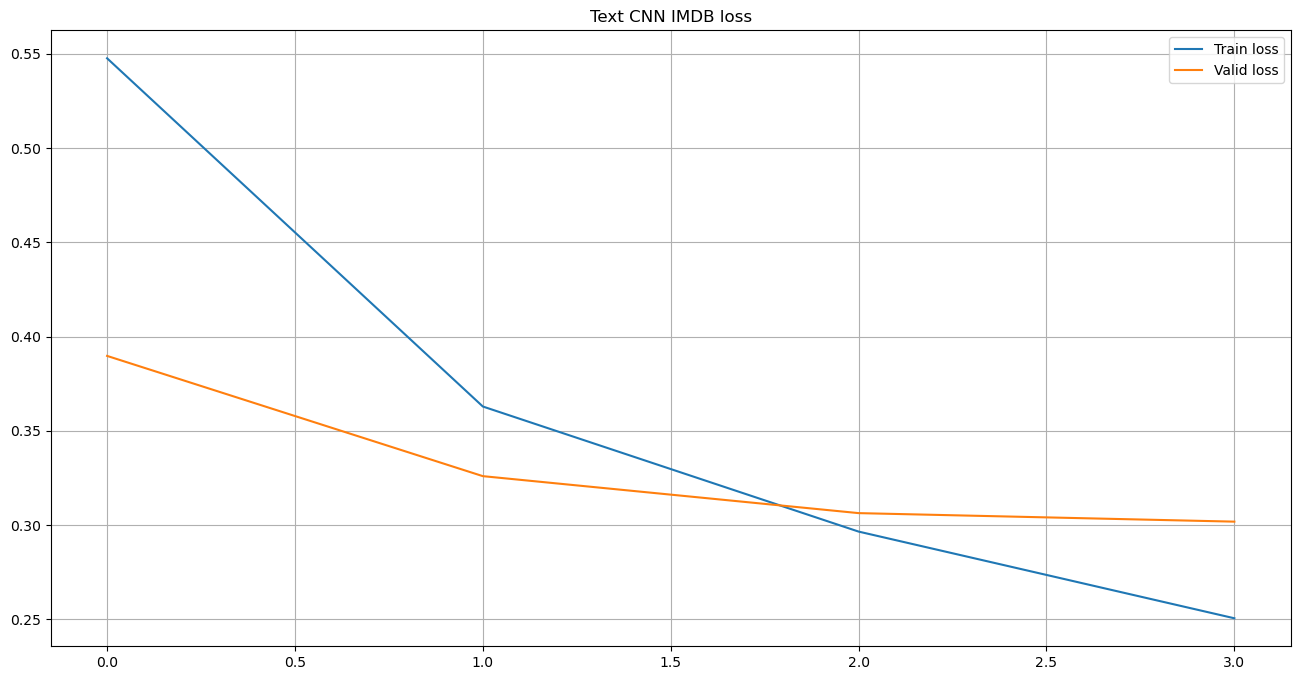

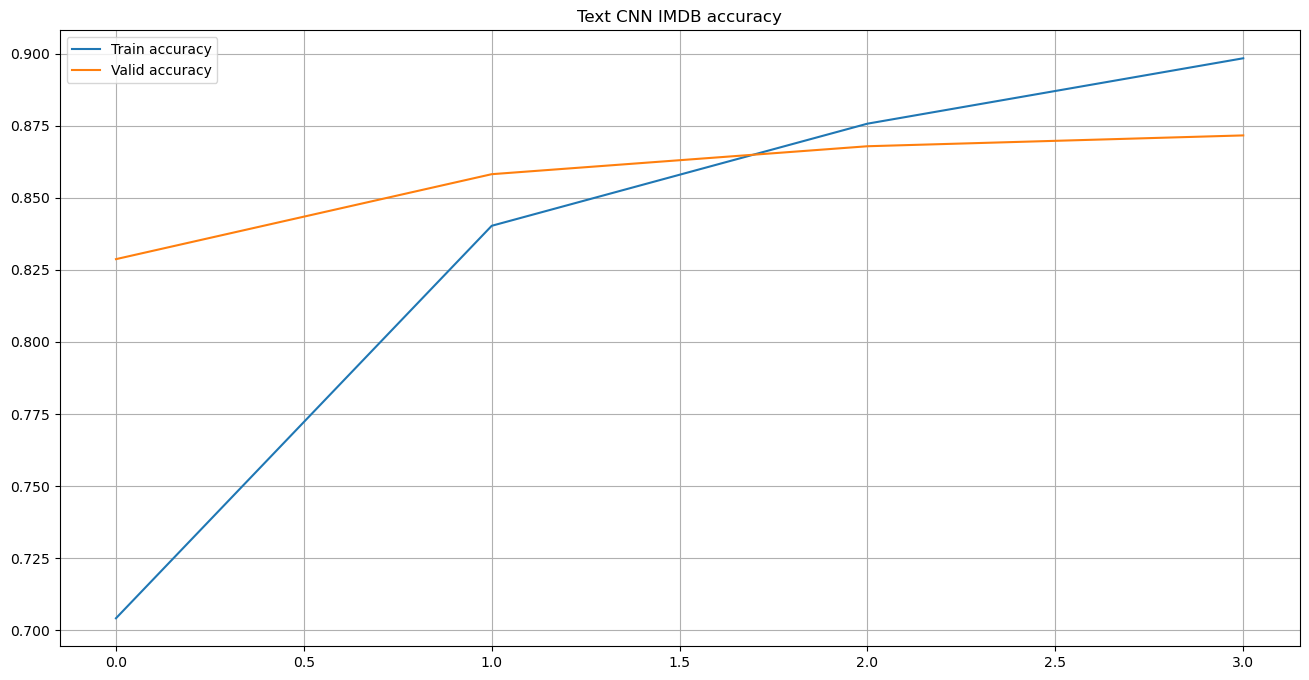

In [189]:
whole_train_valid_cycle(model, train_loader, test_loader, optimizer, loss_fn, device, threshold = 0.87, title = 'Text CNN IMDB', scheduler = scheduler)

In [190]:
test = "By now you know what to expect from a John Wick movie. I thought the franchise was losing a little momentum in chapter 3 so I was worried this could be disappointing. It's not. It's even more on steroids than any Wick before! Even close to 3 hours it doesn't feel to long which is very special for a action movie. This franchise has set new standards. If anybody says a movie is good like John Wick, it better f'n be! The set pieces as everyone mentioned before are really insane this time. The Tokyo sceney with illuminated cherry blossoms was beautiful. The only super illogical thing that bothered me was that nobody flinched at the nightclub, eventually they did but after a whole 10 minute beatdown through the whole club, but then again it's a shady nightclub for high table people. If you liked the first three movies, get your ass to the cinema. Yeah."

In [191]:
def get_sentiment(text):
    txto = torch.LongTensor(vocab.encode(text))
    txto = txto.unsqueeze(0)
    txto = txto.to("cuda")
    predict = int(torch.round(torch.sigmoid(model(txto))))
    if (predict == 1):
        return "negative"
    else:
        return "positive"

In [192]:
get_sentiment(test)

'negative'

In [193]:
test2 = "really bad film i hate it so much"
get_sentiment(test2)

'negative'

In [194]:
test3 = "I left about half way through the movie. Lots of stabbing and banging sounds. If that is your thing you will like it otherwise a lot of mediocre animated action with little substance."
get_sentiment(test3)

'negative'

In [195]:
test4 = df["review"].loc[0]
get_sentiment(test4)

'positive'

In [199]:
test5 = "Yup, it's another good old classic feeling of WOW Now Entertainment, where you watch the bad movements and with the worst disappointments than any movie. Let's come to this part... this... is... horrible.How come you might ask? I am not super religious nor a Christian, but I still am offended how they literally tried to mock a Japanese sushi fish... you heard me right... a sushi fish... ugh. It sure is understandable how they need more cash but obviously, you can't get money from that Christian movie. Thus, the whole movie gets a sequel... what a 'big' surprise.Genuinely offended in short both from this and the sequel, not recommending you all to watch them."

In [200]:
get_sentiment(test5)

'negative'

In [202]:
get_sentiment('i like it so much yeah its really good')

'positive'

## BERT EMBEDDINGS

In [ ]:
from datasets import load_dataset

dataset = load_dataset("imdb", split="train")

np.random.seed(100)
idx = np.random.randint(len(dataset), size=200)